# QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM (QAOA)

In this tutorial we show how to (approximately) solve binary combinatorial optimization problems, using the __Quantum Approximate Optimization Algorithm (QAOA)__, as introduced in Ref.[1]. 
The QAOA algorithm belongs to the class of __hybrid quantum algorithms__ (leveraging both classical as well as quantum compute), that are widely believed to be the working horse for the current __NISQ (noisy intermediate-scale quantum) era__.
In this NISQ era QAOA is also an emerging approach for benchmarking quantum devices and is a prime candidate for demonstrating a practical quantum speed-up on near-term NISQ device [1,4]. 
To validate our approach we benchmark our results with exact results as obtained from classical QUBO solvers. 

We provide a step-by-step walkthrough explaining the QAOA quantum algorithm and show how to build the corresponding parametrized quantum circuit ansatz using the ```Braket``` SDK, with simple modular building blocks (that can be re-used for other purposes). 
We use open-source off-the-shelf ```scipy``` optimizers for classical numerical optimization. 
While we demonstrate our proof-of-concept approach using classical simulators for circuit execution, our code could in principle be run on actual quantum hardware by simply changing the definition of the ```device``` object (provided that the gate set used in the ansatz is supported by the backend, as is the case here for IonQ; for Rigetti we need to apply one more extra trick as shown below).   

## BACKGROUND: HYBRID QUANTUM ALGORITHMS

Quantum computers hold the promise to outperform even the most-powerful classical computers on a range of computational problems in (for example) optimization, chemistry, material science and cryptography.
The canonical set of quantum algorithms (such as Shor's or Grover's quantum algorithms), however, comes with hardware requirements (such as a large number of quantum gates) that are currently not available with state-of-the-art technology. 
Specifically, these algorithms are typically believed to be feasible only with fault-tolerance as provided by quantum error correction. 
In the current __noisy intermediate-sclae (NISQ) era__, near-term quantum computers do not have a large enough number of physical qubits for the implementaiton of error correction protocols, making this canonical set of quantum algorithms unsuitable for near-term devices. Against this background, the near-term focus has widely shifted to the class of __hybrid quantum algorithms__ that do not require quantum error correction. 
In these hybrid quantum algorithms are the noisy __near-term quantum computers are used as co-processors__ only, within a larger classical optimization loop, as sketched in the schematic figure below. 
Here, the undesired effects of noise are suppressed by deliberatedly limiting the quantum circuits on the quantum processing unit (QPU) to short bursts of the calculation, and the need for long coherence times (as required for the standard set of quantum algorithms) is traded for a classical overhead due to (possibly many) measurement repetitions and (essentially error-free) classical processing. 

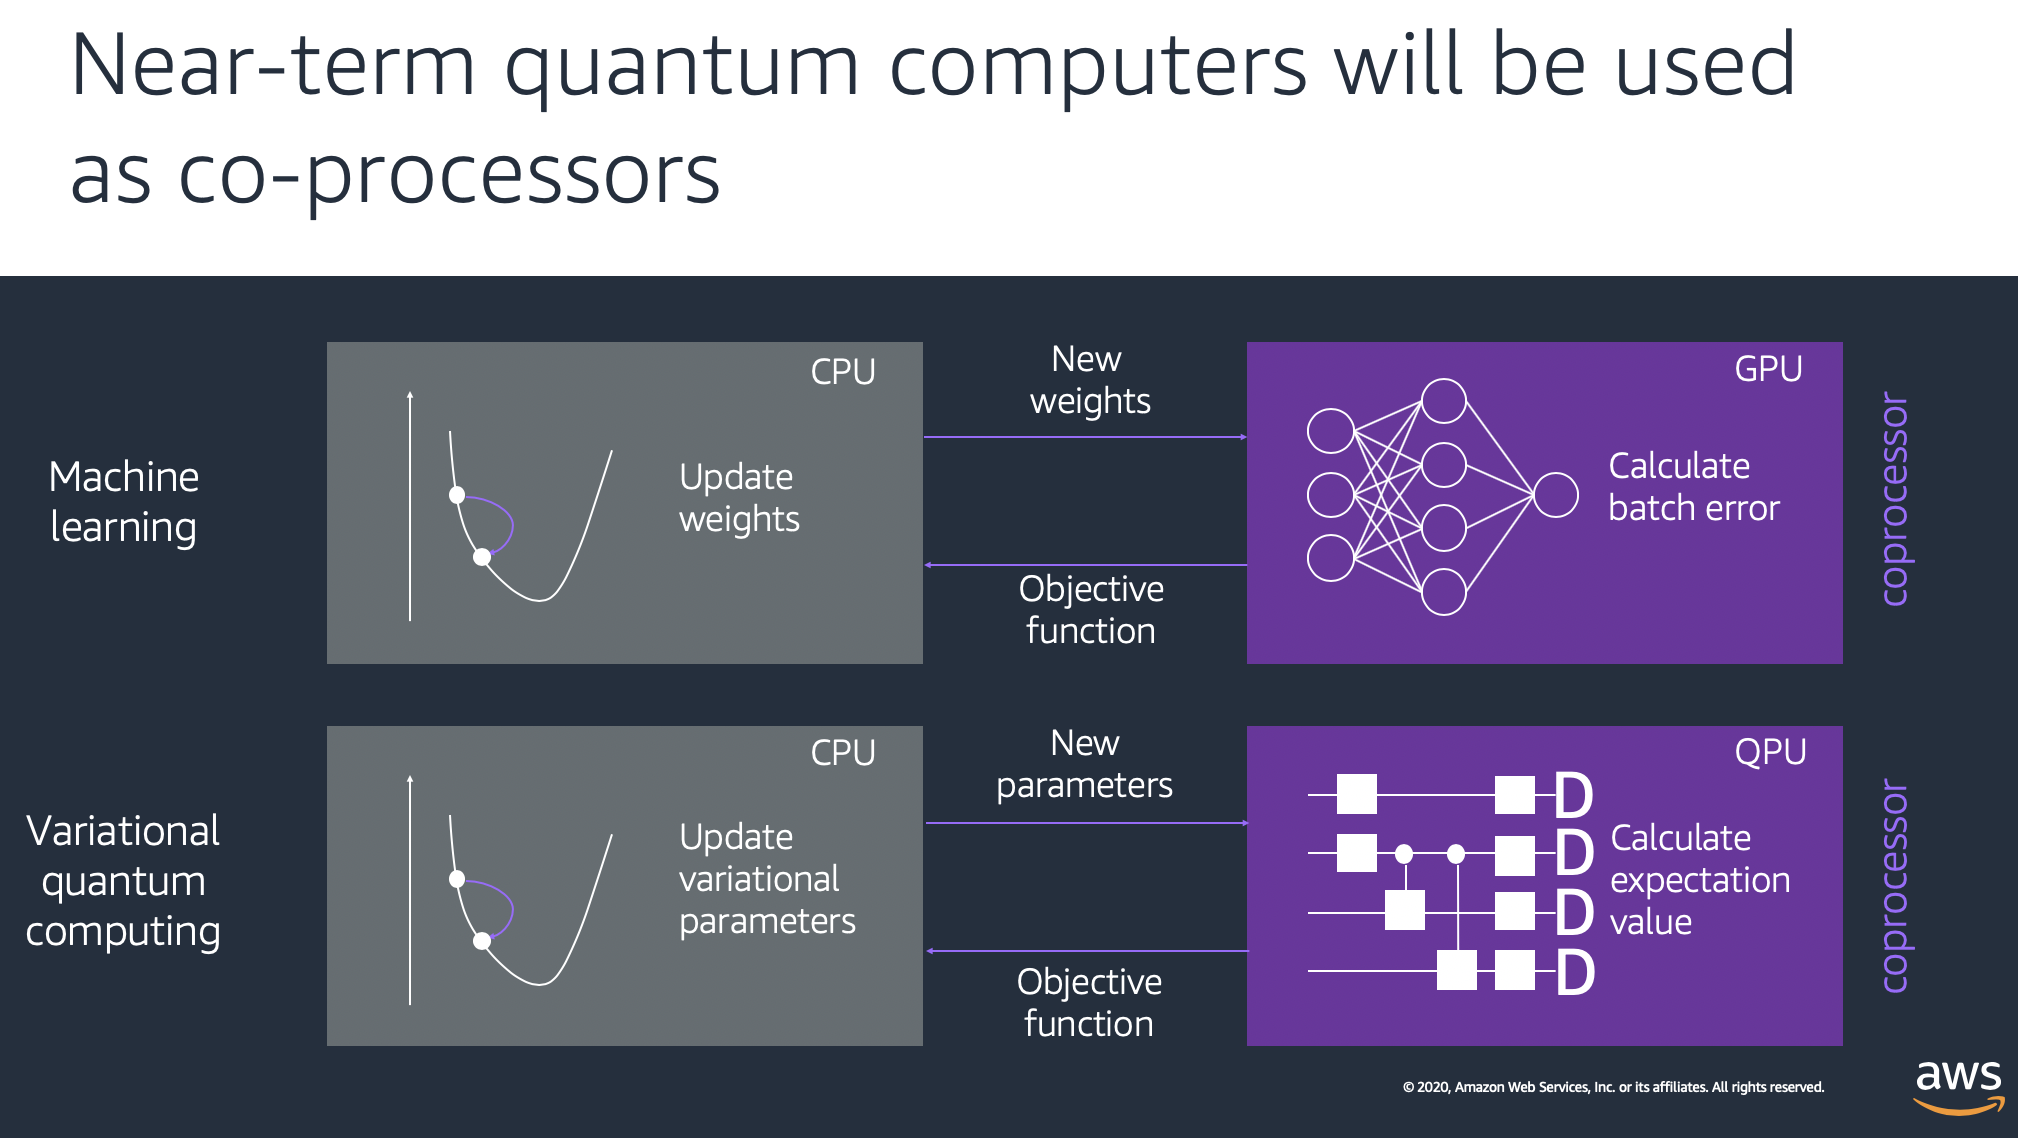

__Variational Quantum Algorithms__: Specifically, variational quantum algorithms such as the Quantum Approximate Optimization Algorithm (QAOA) [1] belong to this emerging class of hybrid quantum algorithms. 
These are widely believed to be promising candidates for the demonstration of a __quantum advantage__, already with near-term (NISQ) devices in areas such as quantum chemistry [2], condensed matter simulations [3], and discrete optimization tasks [4].

__Variational Quantum Computing vs. Deep Learning__: The working principle of variational quantum computing is very much reminiscent of training deep neural networks: 
When you train a neural network, you have an objective function that you want to minimize, typically characterized by the error on your training set. 
To minimize that error, typically you start out with an initial guess for the weights in your network. 
The coprocessor, in that case a GPU, takes these weights which define the exact operation to execute and the output of the neural network is computed. 
This output is then used to calculate the value of your objective function, which in turn is used by the CPU to make an educated guess to update the weights and the cycle continues. 
Variational quantum algorithms, a specific form of hybrid algorithms, work in the very same way, using parametrized quantum circuits rather than parametrized neural networks and replacing the GPU with a QPU. 
Here, you start with an initial guess for the parameters that define your circuit, have the QPU execute that circuit, perform measurements to calculate an objective function, pass this value (together with the current values of the parameters) back to the CPU and have this *classical* CPU update the parameters based on that information. 

Of course, coordinating that workflow for quantum computers is much more challenging than in the previous case. Quantum computers are located in specialized laboratory facilities, are typically single threaded, and have special latency requirements. 
This is exactly the undifferentiated heavy-lifting that Amazon Braket takes away for you such that we can focus on our scientific problem. 
For the sake of this introductory tutorial, we simply use a classical circuit simulator (that mimick the behaviour oc a quantum machine) as backend to execute our quantum circuits.
Within Amazon Braket, the workflow, however, is exactly the same. 

## BACKGROUND: QUADRATIC BINARY OPTIMIZATION PROBLEMS

__Combinatorial optimization__: 
Combinatorial optimization problems are ubiquitious across many areas of science and application areas. 
Applications can be found (for example) in logistics, scheduling, planning, and portfolio optimization.
In a nutshell combinatorial optimization problems are problems involving a large number of yes/no decisions with each set of decisions yielding a corresponding objective function value, like a cost or profit value. 
Because of the combinatorial explosion of the solution space with the number of variables, finding good solutions is a daunting task and extremely difficult.  

__QUBO problems__: The QUBO ([Quadratic Unconstrained Binary Optimization](https://en.wikipedia.org/wiki/Quadratic_unconstrained_binary_optimization)) model unifies a rich variety of NP-hard combinatorial optimization problems: 
Famous examples include Quadratic Assignment Problems, Capital Budgeting Problems, Task Allocation Problems and Maximum-Cut Problems. 
For more details we refer to the excellent review and tutorial on QUBO problems presented in Ref.[5].

__Maximum Cut__: Among the class of QUBO problems, Maximum Cut (in short: MaxCut) is paradigm combinatorial optimization problem. 
Given a graph $G=(V,E)$ with vertex set $V$ and edge set $E$, we seek partition of $V$ into two subsets with maximum cut. 
In short, we have to color every node either blue or red and we score a point whenever an edge connects two nodes with different colors. 
We then would like to find the solution with the highest score. 
Applications thereof can be found in for example (i) clustering for marketing purposes (segment your customer base into different clusters for targeted marketing) or (ii) portfolio optimization in finance (vertex corresponds to asset, with color referring to sell or buy decisions. 
Again, the problem in this specific graph coloring problem is that there are $2^𝑁$ possible solutions for $N$ nodes (an exponential explosion in possibilities), making it impossible to enumerate all possible candidates for relevant system sizes. 

__Ising Hamiltonian__: Importantly, there is a fundamental correspondence between QUBO problems and Ising problems in physics. 
Specifcally, we can encode the Maximum Cut problem as a __minimization problem__ of an Ising Hamiltonian, where the (classical) cost function reads 

$$H_{C}=\sum_{i>j} J_{i,j} z_{i} z_{j},$$

with Ising variables $z_{i}=-1,1$ and the Ising matrix $J$ encoding the weigths of the edges. 
For the sake of this discussion, we ignore potential linear terms and constant offsets (that do not affect the optimal solution $z$ anyway). 
In short, the cost Hamiltonian $H_{C}$ assigns a number to every bitstring $z=(z_{1},z_{2},\dots)$, and we would like to find the lowest number possible. 
This will be the optimal assignment and solution to our problem. 

## BACKGROUND: THE QUANTUM APPROXIMATE OPTIMIZATION ALGORITHM

In this tutorial we will try to solve for the optimal _classical_ bitstring $z$ using the Quantum Approximate Optimization Algorithm, in short QAOA. 
To this end, we first promote the classical spin variables $z_{i}=-1,1$ to quantum-mechanical variables $\sigma_{i}^{z}$ (with the Pauli matrix $\sigma_{i}^{z}$ representing the observable corresponding to spin along the $z$ coordinate axis in three-dimensional Euclidean space $\mathbb{R}^{3}$. ). 
This leads to the following quantum mechanical cost Hamiltonian encoding the optimization problem

$$\hat{H}_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z},$$

which can be written as a matrix of size $(2^{N}, 2^{N})$ with diagonal elements only corresponding to all possible classical values for the cost function $H_{C}$. 
The ground state of $\hat{H}_{C}$ corresponds to the optimal solution of the classical combinatorial problem.

Finding this ground state is generically hard. 
To approximate this groundstate, QAOA prepares a parametrized ansatz state (corresponding to a parameterized  gate  sequence),  whose  parameters  are iteratively updated by a classical optimizer. 
Specifically, QAOA involves a specific ansatz wavefunction parametrized by a parameter family $(\vec{\beta}, \vec{\gamma})$, embedded into a larger calssical optimization loop to find the optimal values for these parameters. 
As shown in Ref.[1], good approximate solutions to the problem class considered here can be found by preparing the variational state 

$$|\gamma, \beta \rangle = U_{x}(\beta_{p})U_{zz}(\gamma_{p}) \cdots U_{x}(\beta_{1})U_{zz}(\gamma_{1}) |s\rangle$$

with single qubit rotations induced by $U_{x}(\beta) = \exp(-i\beta \sum_{i}\sigma_{i}^{x})$, 
and interactions described by $U_{zz}(\gamma) = \exp(-i\gamma H_{C})$,
starting initially from a product of $\sigma^{x}$ eigenstates, i.e.,
$|s\rangle =|-,-,\dots\rangle$, with $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
The family of states $|\gamma, \beta \rangle$ is prepared by alternating single-qubit operations $U_{x}(\beta_{p})$ with targeted spin-spin interactions generated by the cost Hamiltonian $H_{C}$. 
The depth $p$ can be interepreted as a hyperparameter. 
For $p$ layers of QAOA blocks, there are $2p$ classical parameters to optimize over, 
since each layer $k$ is characterized by just two variational parameters, $\gamma_{k}$ and $\beta_{k}$. 
The preparation step outlined above is followed by a measurement in the computational basis, giving a classical string $z$, with which one can evaluate the objective function $H_{C}$ of the underlying combinatorial problem at hand. 
Taking several measurements shots one can build the expectation value $E(\beta, \gamma) = \langle H_{C} \rangle$ that we report as the objective function to the classical minimizer (while other choices could be possible as well). 
Repeating this procedure will provide an optimized string $z$, with the quality of the result improving as the depth of the quantum circuit $2p$ is increased [1]. 
In fact, in principle (in the absence of noise and other imperfections), QAOA can reach the global optimum of any cost function in the limit $p \rightarrow \infty$ [1], approaching the adiabatic protocol. 
Thus, in theory the computational power of QAOA increases with $p$, but in practice the number of layers that can be executed withour errors on NISQ devices is limited due noise and imperfections. 
Since we are primarliy interested in solving the classical optimization problem, within this routine it is sufficient to keep track of the best classical bitstring. This means that the waefunction prepared by the quantum circuit $|\gamma, \beta \rangle$ has to have some overlap with the classical bitstring $z^{*}$ that we can read out in the measurement shots. 

## IMPORTS and SETUP

For classical benchmarking we will be using the python library ```pyqubo```, as used in our helper script ```utils_classical```. If not already present in your virtual environment, you can install this library simply with ```pip install pyqubo```. 

In [1]:
# general imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import time
from datetime import datetime
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# fix random seed for reproducibility
np.random.seed(0)

In [3]:
# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import Circuit 
from braket.aws import AwsQuantumSimulator, AwsSession
from braket.devices import LocalSimulator

In [4]:
from utils_classical import plot_colored_graph, plot_colored_graph_simple, solve_classical_ising
# auto reload external files, so that we can edit the external .py file and immediately see the changes here
%load_ext autoreload
%autoreload 2

__NOTE__: Please enter your desired backend device and S3 location (bucket and key) below. If you are working with the local simulator ```LocalSimulator()``` you do not need to specify any S3 location. However, if you are using a different cloud-based backend you need to specify a S3 location where your results will be stored. In this case you need to replace the API call ```device.run(circuit, shots=SHOTS).result()``` below with ```device.run(circuit, s3_folder, shots=SHOTS).result()```. 

In [5]:
# set up backend: Local Schroedinger Simulator
device = LocalSimulator()

# setup s3 folder (not needed for the LocalSimulator backend, but required for all other backends)
my_bucket = "braket-bravehearts"
my_prefix = "simulation-output"
s3_folder = (my_bucket, my_prefix)

## PROBLEM SETUP

We consider a graph coloring problem.
Given a graph $G=(V,E)$, made of a set vertices (also called nodes) $V$ and edges $E$, our goal is to color each node red or blue, then score a point for each node that is next to a node of different color. 
We strive to find the optimal coloring that scores the largest number of points.
To this end, we will address the dual problem of finding the minimum energy of the corresponding Ising Hamiltonian. 
To get started, we first use the open-source ```networkx``` library to visualize the problem graph. 
Feel free to play with the parameters $n$ (for the number of nodes) and $m$ (for the number of edges) below to consider other graphs of your choice. 

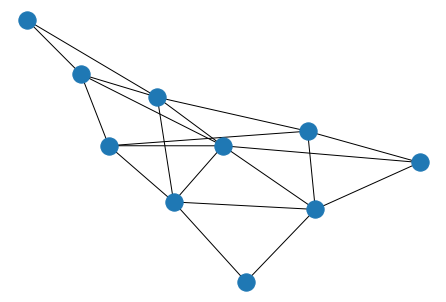

In [6]:
# setup Erdos Renyi graph
n = 10  # 10 nodes
m = 20  # 20 edges

# define graph object
G = nx.gnm_random_graph(n, m, seed=42)
# positions for all nodes
pos = nx.spring_layout(G)

# draw graph
nx.draw(G, pos)
plt.show()

In [7]:
# get Ising matrix from graph object
Jfull = nx.adjacency_matrix(G).todense()
Jfull = np.array(Jfull)
N = Jfull.shape[0]

# get upper triangular matrix
J = np.zeros((N, N))
for ii in range(0, N):
    for jj in range(ii+1, N):
        J[ii][jj] = Jfull[ii][jj]

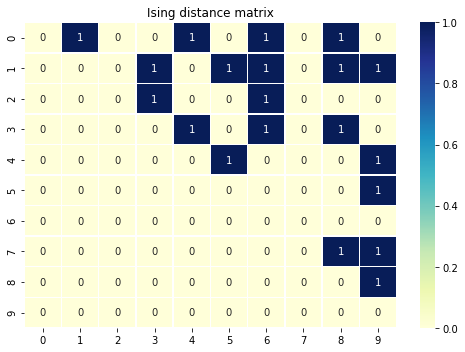

In [8]:
# plot Ising matrix
plt.figure(figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

## IMPLEMENTATION OF QAOA WITH BRAKET 

In this section we develop a set of useful helper functions that we will explain in detail below. 
Specifically we provide simple building blocks for the core modules of our QAOA algorithm, that is (i) a function called ```circuit``` that defines the parametrized ansatz, (ii) a function called ```objective_function``` that takes a list of variational parameters as input, and returns the cost associated with those parameters and finally (iii) a function ```train``` to run the entire QAOA algorithm for given ansatz. 
This way we can solve the problem in a clean and modular approach.

<span style="color:red">__TODO__:</span> 
* Load these functions from helper ```utils.py``` once polished. 
* Check Rigetti backend for implementation of ZZ gate. 
* Get rid of GLOBAL variables. In particular, use ```minimize(objective_function, params0, args=(b_field, verbose), options=options, ...``` as in VQE TIM tutorial.
* POSTPROCESSING: Implement postprocessing with new result_type features of SDK. 

In [9]:
def ZZgate(q1, q2, gamma):
    """
    function that returns a circuit implementing exp(-i \gamma Z_i Z_j) using CNOT gates if ZZ not supported
    """
    
    # get a circuit
    circ_zz = Circuit()
    
    # construct decomposition of ZZ
    circ_zz.cnot(q1, q2).rz(q2, 2*gamma).cnot(q1, q2)
    
    return circ_zz


# function to implement evolution with driver Hamiltonian
def driver(beta):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    for qubit in range(N):
        gate = Circuit().rx(qubit, 2 * beta)
        circ.add(gate)
    return circ


# helper function for evolution with cost Hamiltonian
def cost_circuit(gamma):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    for ii in range(N):
        for jj in range(ii + 1, N):
            if device.name == 'Rigetti':
                gate = ZZgate(ii, jj, gamma * J[ii, jj])
                circ.add(gate)
            else:
                gate = Circuit().zz(ii, jj, angle=2*gamma*J[ii, jj])
                circ.add(gate)
    return circ


# function to build the QAOA circuit with depth p
def circuit(params):
    """
    function to return full QAOA circuit
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    X_on_all = Circuit().x(range(0, N))
    circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, N))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add circuit layers
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm]))
        circ.add(driver(betas[mm]))

    return circ


# function that computes cost function for given params
def objective_function(params):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    print('==================================' * 2)
    global CYCLE
    CYCLE += 1
    print('Calling the quantum circuit. Cycle:', CYCLE)

    # obtain a quantum circuit instance from the parameters
    qaoa_circuit = circuit(params)

    # classically simulate the circuit
    # execute the correct device.run call depending on whether the backend is local or cloud based
    if device.name == 'DefaultSimulator':
        task = device.run(qaoa_circuit, shots=SHOTS)
    else:
        task = device.run(qaoa_circuit, s3_folder, 
                          shots=SHOTS, poll_timeout_seconds=3*24*60*60)
    
    # get result for this task
    result = task.result()

    # get metadata
    metadata = result.task_metadata
    
    ##########################################
    ### POSTPROCESSING ####
    ##########################################
    
    # convert results (0 and 1) to ising (-1 and 1)
    meas_ising = result.measurements
    meas_ising[meas_ising == 0] = -1

    # get all energies (for every shot): (n_shots, 1) vector
    all_energies = np.diag(np.dot(meas_ising, np.dot(J, np.transpose(meas_ising))))

    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    print('Minimal energy:', energy_min)
    optimal_string = meas_ising[np.argmin(all_energies)]
    print('Optimal classical string:', optimal_string)

    # store optimal (classical) result/bitstring
    global ENERGY_OPTIMAL
    global BITSTRING
    if energy_min < ENERGY_OPTIMAL:
        ENERGY_OPTIMAL = energy_min
        BITSTRING = optimal_string

    # energy expectation value
    energy_expect = np.sum(all_energies) / SHOTS
    print('Approx energy expectation value (cost):', energy_expect)
    # send metrics to CloudWatch
    print(f'cost_avg={energy_expect};')

    # NOTE: could consider other definitions of cost function
    cost = energy_expect

    return cost


# The function to execute the training: run classical minimization.
def train(options, p=3):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print('Starting the training.')

    print('==================================' * 3)
    print('OPTIMIZATION for circuit depth p={depth}'.format(depth=p))

    # initialize
    cost_energy = []
    angles = []

    # randomly initialize variational parameters within appropriate bounds
    gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
    beta_initial = np.random.uniform(0, np.pi, p).tolist()
    params0 = np.array(gamma_initial + beta_initial)
    params0[0] = 0.01
    params0[p] = 0.4
    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    # run classical optimization (example: method='Nelder-Mead')
    result = minimize(objective_function, params0, options=options, method='SLSQP', bounds=bnds)

    # store result of classical optimization
    result_energy = result.fun
    cost_energy.append(result_energy)
    print('Optimal avg energy:', result_energy)
    result_angle = result.x
    angles.append(result_angle)
    print('Optimal angles:', result_angle)
    print('Training complete.')

    return result_energy, result_angle

<span style="color:red">__TODO__:</span> 
Check out this example for new result types: 

In [10]:
# #Add desired results_types
# circ.probability()

# # define task
# if device.name == 'DefaultSimulator':
#     task = device.run(circ, shots=shots)
# else:
#     task = device.run(circ, s3_folder, shots=shots, poll_timeout_seconds=poll_time)

# # get result for this task
# result = task.result()

# # get metadata
# metadata = result.task_metadata

# # get output probabilities (see result_types above)
# probs_values = result.values[0]

# # get measurement results
# measurements = result.measurements
# measured_qubits = result.measured_qubits
# measurement_counts = result.measurement_counts
# measurement_probabilities = result.measurement_probabilities

## VISUALIZATION OF THE QAOA ANSATZ

Let us first visualize our parametrized QAOA ansatz for a small number of qubits and fixed (i.e., not optimized) parameters. 
For convenience, the parameters are dispalyed in the circuit (up to a factor of $2$ we have added in our ansatz definition). 
First we prepare the state $|0,0,\dots\rangle \rightarrow |-,-,\dots\rangle$, with the superposision state $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
Following the discussion above, we choose to start out with this state as it is the minimal energy state of the simple driver Hamiltonian $H_{B}$. 
This state preparation is followed by one layer of the QAOA ansatz, consisting of evolution with the cost Hamiltonian by $\exp(-i\gamma H_{C})= \prod_{j,l}\exp(-i\gamma J_{j,l}\sigma_{j}^{z}\sigma_{l}^{z}) = \prod_{j,l} ZZ_{j,l}(2\gamma J_{j,l})$, followed by the single-qubit driving term, $\exp(-i\beta H_{B})= \prod_{j} \exp(-i\beta \sigma_{j}^{x})= \prod_{j} R_{j}^{(x)}(2\beta)$.

In [11]:
# set number of qubits and fix parameters
N = 2
gammas = [0.1]
betas = [0.3]
params = gammas + betas

# get circuit ansatz
my_simple_circuit = circuit(params)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : |0|1|   2   |   3   |
                          
q0 : -X-H-ZZ(0.2)-Rx(0.6)-
          |               
q1 : -X-H-ZZ(0.2)-Rx(0.6)-

T  : |0|1|   2   |   3   |


We see that our ansatz produces the expected result for shallow QAOA with $p=1$. 
We run one more sanity check for $p=2$ below. 

In [12]:
# set number of qubits and fix parameters
N = 2
gammas = [0.1, 0.2]
betas = [0.3, 0.4]
params = gammas + betas

# get circuit ansatz
my_simple_circuit = circuit(params)

# print test ansatz circuit
print('Printing test circuit:')
print(my_simple_circuit)

Printing test circuit:
T  : |0|1|   2   |   3   |   4   |   5   |
                                          
q0 : -X-H-ZZ(0.2)-Rx(0.6)-ZZ(0.4)-Rx(0.8)-
          |               |               
q1 : -X-H-ZZ(0.2)-Rx(0.6)-ZZ(0.4)-Rx(0.8)-

T  : |0|1|   2   |   3   |   4   |   5   |


## QAOA SIMULATION ON LOCAL SCHROEDINGER SIMULATOR

We are now all set to run some QAOA simulation experiments. 
First of all, you can play and experiment yourself with the number of qubits $N$. 
Secondly, you may also experiment with the classical optimizer. 
Since we are using an off-the-shelf ```scipy``` minimizer (as described in more detail [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)), you can simply swap between different optimizers by setting the ```method``` parameter accordingly, as done above in the line ```result = minimize(..., method='SLSQP')```. 
Some popular options readily availbale within this library include *Nelder-Mead*, *BFGS* and *COBYLA*. 
As a precautionary warning, note that the classical optimization step may get stuck in a local optimum, rather than finding the global minimum for our parametrized QAOA ansatz wavefunction. 
To address this issue, we may run several optimization loops, starting from different random parameter seeds. 
While this brute-force approach does not provide any guarantee to find the glocal optimum, from a pragmatic point of view at least it does increase the odds of finding an acceptable solution, at the expense of potentially having to run many more circuits on the QPU.

In [13]:
# set up hyperparameters
p = 2  # circuit depth for QAOA
print('Circuit depth hyperparameter:', p)
SHOTS = 1000

# set up the problem
N = J.shape[0]
print('Problem size:', N)
CYCLE = 0
# initialize reference solution (simple guess)
BITSTRING = -1 * np.ones([N])
ENERGY_OPTIMAL = np.dot(BITSTRING, np.dot(J, BITSTRING))
# set options for classical optimization
# 'maxiter'=100, 'ftol': 1e-06
options = {'disp': True}
# options = {'disp': True, 'ftol': 1e-08}

##################################################################################
# run QAOA optimization on graph 
##################################################################################

# kick off training
start = time.time()
result_energy, result_angle = train(options=options, p=p)
end = time.time()
# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energy:', ENERGY_OPTIMAL)
print('Optimal classical bitstring:', BITSTRING)

##################################################################################
# Compute output and dump to pickle
##################################################################################

out = {'p': p, 'N': N,
       'ENERGY_OPTIMAL': ENERGY_OPTIMAL, 'BITSTRING': BITSTRING,
       'result_energy': result_energy, 'result_angle': result_angle}

# store results: dump output to pickle with timestamp in filename
time_now = datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')
results_file = 'results-'+time_now+'.pck'
pickle.dump(out, open(results_file, "wb"))
# you can load results as follows
# out = pickle.load(open(results_file, "rb"))

Circuit depth hyperparameter: 2
Problem size: 10
Starting the training.
OPTIMIZATION for circuit depth p=2
Calling the quantum circuit. Cycle: 1
Minimal energy: -10.0
Optimal classical string: [-1  1  1 -1  1 -1 -1 -1  1 -1]
Approx energy expectation value (cost): -0.264
cost_avg=-0.264;
Calling the quantum circuit. Cycle: 2
Minimal energy: -10.0
Optimal classical string: [-1  1 -1 -1  1 -1  1  1  1 -1]
Approx energy expectation value (cost): -0.084
cost_avg=-0.084;
Calling the quantum circuit. Cycle: 3
Minimal energy: -10.0
Optimal classical string: [-1  1  1 -1  1 -1  1  1  1 -1]
Approx energy expectation value (cost): -0.152
cost_avg=-0.152;
Calling the quantum circuit. Cycle: 4
Minimal energy: -10.0
Optimal classical string: [-1  1  1 -1  1 -1  1 -1  1 -1]
Approx energy expectation value (cost): -0.35
cost_avg=-0.35;
Calling the quantum circuit. Cycle: 5
Minimal energy: -10.0
Optimal classical string: [-1  1  1 -1  1 -1  1  1  1 -1]
Approx energy expectation value (cost): -0.34
cos

## POSTPROCESSING AND COMPARISON OF OUR QAOA RESULTS WITH CLASSICAL RESULTS

In this section we visualize the results we have found with QAOA. 
Specifically, we display the results found for the variational parameters $\beta$ and $\gamma$ for every layer in our QAOA ansatz. 
Moreover, we show the solution to our graph coloring problem with every node colored either red or blue (recall that there are just two colors since we solve a _binary_ optimization problem).
Finally, we compare these results to results found classically using the open-source ```pyqubo``` package. 
Ideally, the two results should agree with each other but this is not necessarily the case for several reasons: 
First of all, for the original small toy problem we have set up there are several degenerate classical solutions with the same optimal quality. 
The classical and the QAOA approach may find solutions with different coloring configurations but the same quality (that is energy). 
Secondly, with QAOA we are not guranteed to find the optimal solutions. 
Specifcally, the deeper the circuit, the harder the classical optimization problem, and we may get stuck in a local rather than global optimum. 
One brute-force approach is then to just re-run QAOA with different random initial seeds for the parameters $(\beta, \gamma)$.

In [14]:
# print the optimal energy found with QAOA 
print('Optimal energy from managed job:', ENERGY_OPTIMAL)
# print the corresponding bitstring
print('Optimal bit-string from managed job:', BITSTRING)

Optimal energy from managed job: -10.0
Optimal bit-string from managed job: [-1  1  1 -1  1 -1 -1 -1  1 -1]


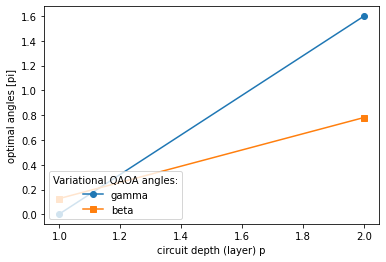

In [15]:
# get results for variational angles
gamma = result_angle[:p]
beta = result_angle[p:]
# get array [1, 2, ..., p]
pa = np.arange(1, p + 1)

# plot angles
fig = plt.figure(1)
plt.plot(pa, gamma / np.pi, '-o', label='gamma')
plt.plot(pa, beta / np.pi, '-s', label='beta')
plt.xlabel('circuit depth (layer) p')
plt.ylabel('optimal angles [pi]')
plt.legend(title='Variational QAOA angles:', loc='lower left')
plt.show()

Minimal energy found from QAOA job: -10.0


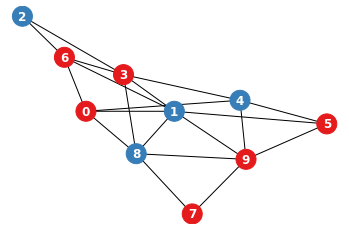

In [16]:
# visualize solution
colorlist = BITSTRING
colorlist[colorlist == -1] = 0

# plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found from QAOA job:', ENERGY_OPTIMAL)

Classical solution: {'s0': 1, 's1': -1, 's2': 1, 's3': 1, 's4': -1, 's5': 1, 's6': -1, 's7': 1, 's8': -1, 's9': 1}
Minimal energy found classically: -10.0


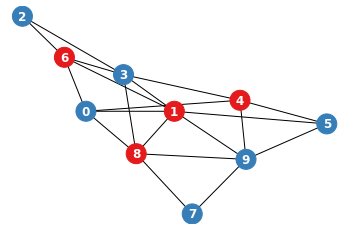

In [17]:
# validate quantum results with classical algorithm
solution, decoded_solution, energy_min, colors_classical = solve_classical_ising(J, N, pos)
# plot classical solution
plot_colored_graph_simple(G, colors_classical, pos)

## SUMMARY

In this notebook we have gone through an end-to-end demo on QAOA and its implementation on Amazon Braket. 
We have built modular core building blocks that may easily adapted to other problems. 
The QAOA routine is tailored towards solving combinatorial optimization problems such as _Maximum Cut_ [4] and arguably one of the most prominent examples of the emerging class of hybrid, variational algorithms and still very much a field of active research today. 
For example, as we increase the circuit depth of QAOA, the classical optimization step becomes incresingly difficult (because of the curse of dimensionality as well known in classical machine learning) and may eaily get stuck in local sub-optimal solutions. 
To address this issue some heuristics have already been developed, for example in Ref.[4], but further improvements will arguably be necessary to fully unlock the potential of this approach. 

---
## REFERENCES

[1] E. Farhi, J. Goldstone, and S. Gutmann, arXiv 1411.4028 (2014).

[2] Y. Cao, J. Romero, J. P. Olson, M. Degroote, P. D. Johnson, M. Kieferov´a, I. D. Kivlichan, T. Menke, B. Peropadre, N. P. Sawaya, et al., Chemical reviews 119,
10856 (2019).

[3] A. Smith, M. Kim, F. Pollmann, and J. Knolle, npj Quantum Information 5, 1 (2019).

[4] L. Zhou, S.-T. Wang, S. Choi, H. Pichler, and M. D. Lukin, arXiv 1812.01041 (2018). 

[5] F. Glover, G. Kochenberger, "A Tutorial on Formulating and Using QUBO Models", arXiv:1811.11538 (2019).

---
## APPENDIX

In [18]:
# Check SDK version
!pip show braket-sdk | grep Version

Version: 0.4.1
